## **1️⃣ Notebook-Beschreibung**

In diesem Notebook erstellen wir eine professionelle End-to-End-Pipeline für eine **XGBoost-Regression** basierend auf Zeitreihen-Verkaufsdaten.

Wir werden folgende Schritte durchführen:

1. 📂 **Google Drive einbinden**: Aufbau einer klaren Projekt- und Verzeichnisstruktur.

2. 📥 **Daten laden**: Importieren der bereits bereinigten Trainingsdaten vom Datenträger.

3. 🛠️ **Feature Engineering**: Erstellung von Zeitreihen-Features (Lags, rollierende Statistiken, Kalender-Features).

4. 🧪 **Train-Test-Split**: Zeitbasierte Aufteilung der Daten in Trainings- und Testreihen.

5. 🤖 **Baseline-Modell**: Training eines ersten XGBoost-Modells und Bewertung der Leistung.

6. 📈 **Visualisierung**: Vergleich von tatsächlichen und vorhergesagten Verkaufszahlen im Zeitverlauf.

7. ⚙️ **Hyperparameter-Tuning**: Optimierung der wichtigsten XGBoost-Parameter mithilfe von **Hyperopt**.

8. 🏆 **Finales Training**: Erneutes Training mit den besten Parametern sowie Speicherung der Ergebnisse und Diagramme.

# **2️⃣ Notebook setup and installation**


## 2.1 Verify Installation


In [2]:
# 📦 Import der XGBoost-Bibliothek für Gradient-Boosting-Modelle
import xgboost as xgb

# 🔢 Ausgabe der XGBoost-Version zur Überprüfung der Installation und Reproduzierbarkeit
print("✅➣➣XGBoost version:", xgb.__version__)

✅➣➣XGBoost version: 3.1.2


In [3]:
# 📦 Standard-Bibliotheken importieren
import os  # 🖥️ Betriebssystem-Interaktion (Dateipfade, Verzeichnisse)
import pandas as pd  # 📊 Datenanalyse und -manipulation (DataFrames)
import numpy as np  # 🔢 Numerische Berechnungen (Arrays, Mathematik)

import sys  # 🐍 System-spezifische Parameter und Funktionen
from pathlib import Path  # 📁 Objektorientierte Dateipfad-Manipulation

# 1️⃣ Projekt-Root-Verzeichnis dynamisch bestimmen (ein Ebene nach oben)
# 🏠 Aktuelles Arbeitsverzeichnis abrufen
cwd = os.getcwd()
# 📍 Aktuelles Verzeichnis ausgeben
print("Current working directory:🏠", cwd)

# 🔝 Projekt-Root = Übergeordnetes Verzeichnis des aktuellen Verzeichnisses
project_root = os.path.abspath(os.path.join(cwd, ".."))
# 📍 Projekt-Root-Pfad ausgeben
print("Project root:📍📍📍", project_root)

# 2️⃣ Projekt-Root zu sys.path hinzufügen (für Python-Imports)
# 🔍 Prüfen, ob Projekt-Root noch nicht in sys.path enthalten ist
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # 📌 Am Anfang der Suchpfadliste einfügen

# ✅ Bestätigung der Hinzufügung ausgeben
print("Project root added to sys.path:📌", project_root)

Current working directory:🏠 /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/notebooks
Project root:📍📍📍 /Users/sadiqqais/Masterschool/Projekt/time_series_projekt
Project root added to sys.path:📌 /Users/sadiqqais/Masterschool/Projekt/time_series_projekt


In [4]:
# 🔧 Eigene Utility-Funktionen aus dem lokalen Modul 'utils' importieren
# 📥 Funktion zum Laden von CSV-Dateien
from utils import load_csv

# 💾 Funktion zum Speichern von DataFrames als CSV-Dateien
from utils import save_csv

# 📅 Funktion zum Laden und Filtern von Daten basierend auf Datumsbereich
from utils import load_data_filtered_by_date

# 🔍 Funktion zum Laden gefilterter CSV-Daten (wahrscheinlich mit weiteren Filtern)
from utils import load_filtered_csv

# 🗺️ Pfadverwaltungsfunktionen aus dem lokalen Modul 'paths' importieren
# 📍 Funktion zum Abrufen von Dateipfaden (wahrscheinlich Projektpfade)
from paths import get_path

In [5]:
# Basis-Projektverzeichnis im Google Drive
base_dir = get_path("root")  # Hauptordner für das Zeitreihenprojekt

# Unterverzeichnisse für die Datenorganisation
raw_subdir = get_path("raw")  # Für Rohdaten (originale, unbearbeitete Daten)
cleaner_subdir = get_path("cleaner") # Für bereinigte Daten (bereinigt von Fehlern/Unstimmigkeiten)
feature_subdir = get_path("features")  # Für feature-engineering-Daten (abgeleitete Merkmale)
filtered_subdi = get_path("filtered")


# Dateiname der bereinigten Trainingsdaten
filename = "train_cleaned.csv"  # Die CSV-Datei mit den vorbereiteten Trainingsdaten

## 2.2 Datei- Holaden

In [6]:
# 📂 Lädt die bereinigte CSV-Datei in einen Pandas DataFrame
# 📁 Quellordner für die Features (zuvor definiertes feature_subdir)
folder_name = feature_subdir

# 🏷️ Name der Tabelle/Datei (ohne Dateierweiterung) im Quellordner
table_name = "train_features"

# 🔎 Filterparameter für die Datenauswahl
filters = {
    "MAX_DATE": "2014-04-01",  # ⏱️ Maximales Datum (Daten bis einschließlich dieses Datums)
    "STORE_IDS": [24],         # 🏪 Liste der Shop-IDs (hier nur Shop 24)
    "ITEM_IDS": [105577]       # 🏷️ Liste der Artikel-IDs (hier nur Artikel 105577)
}

# 📁 Zielordner für die gefilterten Daten (hier "filtered")
filter_folder = "filtered"

# 🔄 Flag, ob Neuberechnung erzwungen werden soll (False = verwende vorhandene gefilterte Datei)
force_recompute = False

# 📊 Aufruf der Funktion zum Laden der gefilterten Daten
df = load_filtered_csv(
    folder_name=folder_name,      # 📂 Quellordner
    table_name=table_name,        # 🏷️ Quelltabelle
    filters=filters,              # 🔎 Anzuwendende Filter
    force_recompute=force_recompute,  # 🔄 Neuberechnungsflag
)

# 👀 Zeigt eine zufällige Stichprobe von 10 Zeilen des DataFrames an (Überblick über die Daten)
df.sample(10)

🔍 No cached file found. Computing filtering...
📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/processed/features
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/processed/features/train_features
📊 Dataset geladen: 'train_features' | Zeilen: 35,069,356 | Spalten: 19



,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_3d_mean,unit_sales_7d_mean,unit_sales_14d_mean,unit_sales_30d_mean,unit_sales_3d_median,unit_sales_7d_median,unit_sales_14d_median,unit_sales_30d_median
14918141,51,1047680,2013-01-02,41542.0,12.0,False,0.921808,2013,1,2,2,12.000000,12.000000,12.000000,12.000000,12.0,12.0,12.0,12.0
32615659,51,2026369,2015-06-09,0.0,0.0,False,0.000000,2015,6,9,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
10215620,36,765520,2015-04-17,44984497.0,4.0,False,1.316567,2015,4,17,4,2.666667,2.000000,1.714286,1.266667,2.0,2.0,2.0,1.0
27697121,34,1948448,2017-07-02,120829537.0,1.0,False,-0.385789,2017,7,2,6,0.333333,1.000000,0.500000,0.233333,0.0,1.0,0.0,0.0
17100086,32,1113872,2014-10-18,33309111.0,4.0,False,0.916355,2014,10,18,5,2.000000,1.571429,1.642857,1.633333,1.0,1.0,1.0,1.0
10818165,51,807495,2016-01-28,68984390.0,1.0,False,-0.855207,2016,1,28,3,0.666667,2.428571,3.642857,3.333333,1.0,2.0,3.0,3.0
5445349,26,378332,2016-11-02,0.0,0.0,False,0.000000,2016,11,2,2,0.666667,0.571429,0.785714,0.766667,1.0,1.0,1.0,1.0
18082916,28,1153584,2017-07-10,121681658.0,7.0,False,-0.609092,2017,7,10,0,16.000000,12.428571,15.285714,15.733333,20.0,7.0,7.5,11.5
26807139,32,1920059,2014-12-12,0.0,0.0,False,0.000000,2014,12,12,4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
24055102,34,1463788,2013-06-20,0.0,0.0,False,0.000000,2013,6,20,3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



📅 Date Range:
   Start: 2013-01-02
   End:   2017-08-15
   Days:  1687
🔎 Applying filters...
✅ Filtered shape: (455, 19)
💾 Saved filtered dataset to: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/processed/filtered/train_features__MAXDATE-2014-04-01__STORE-24__ITEM-105577.csv


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score,year,month,day,day_of_week,unit_sales_3d_mean,unit_sales_7d_mean,unit_sales_14d_mean,unit_sales_30d_mean,unit_sales_3d_median,unit_sales_7d_median,unit_sales_14d_median,unit_sales_30d_median
76201,24,105577,2013-10-15,0.0,0.0,False,0.000000,2013,10,15,1,0.000000,0.428571,1.000000,1.066667,0.0,0.0,0.5,1.0
76312,24,105577,2014-02-03,18386601.0,3.0,False,0.448682,2014,2,3,0,1.666667,1.428571,1.500000,1.566667,1.0,1.0,1.0,1.0
76078,24,105577,2013-06-14,0.0,0.0,False,0.000000,2013,6,14,4,1.666667,2.142857,1.500000,1.666667,2.0,2.0,1.0,1.0
76273,24,105577,2013-12-26,0.0,0.0,False,0.000000,2013,12,26,3,0.000000,0.571429,1.142857,1.366667,0.0,0.0,0.0,1.0
76283,24,105577,2014-01-05,16553677.0,2.0,False,-0.191414,2014,1,5,6,4.666667,2.714286,1.714286,1.633333,5.0,2.0,1.5,1.0
76077,24,105577,2013-06-13,6902706.0,2.0,False,-0.191414,2013,6,13,3,1.666667,2.142857,1.642857,1.700000,2.0,2.0,1.5,1.0
76101,24,105577,2013-07-07,7988120.0,4.0,False,1.088778,2013,7,7,6,1.333333,1.714286,1.571429,1.566667,0.0,2.0,1.0,1.0
76029,24,105577,2013-04-26,4781437.0,4.0,False,1.088778,2013,4,26,4,2.666667,1.714286,2.071429,1.633333,3.0,1.0,1.5,1.0
76268,24,105577,2013-12-21,0.0,0.0,False,0.000000,2013,12,21,5,0.333333,1.571429,1.500000,1.400000,0.0,1.0,1.0,1.0
76054,24,105577,2013-05-21,5877107.0,4.0,False,1.088778,2013,5,21,1,1.666667,1.142857,1.142857,1.533333,1.0,1.0,1.0,1.0


## 2.3 Import core libraries

Imports all required Python packages for data handling, modeling, tuning, and visualization.


In [7]:
# 📦 Import der benötigten Bibliotheken für Datenverarbeitung, Visualisierung und Modellierung

import pandas as pd  # 📊 Datenmanipulation und -analyse
import numpy as np   # 🔢 Numerische Berechnungen und Array-Operationen
import matplotlib.pyplot as plt  # 📈 Visualisierung und Plotting

import xgboost as xgb  # 🌳 XGBoost-Modell für Gradient Boosting

# 🤖 Scikit-learn Importe für Modellvalidierung und Metriken
from sklearn.model_selection import train_test_split, cross_val_score  # ✂️ Datenaufteilung und Kreuzvalidierung
from sklearn.metrics import mean_squared_error  # 📏 Fehlermetrik (Mittlerer quadratischer Fehler)

# 🧪 Installiere Optuna für Hyperparameter-Optimierung (einfacher und moderner als Hyperopt)
%pip install optuna

import optuna  # 🎯 Hyperparameter-Optimierungs-Bibliothek
from optuna.samplers import TPESampler  # 🔍 TPE-Sampler für effiziente Suche

# 📥 Importieren Sie nun Ihre Daten (bereits in vorheriger Zelle geladen)
# df = pd.read_csv('Ihre_Daten.csv')

Note: you may need to restart the kernel to use updated packages.


In [8]:
# 📦 Zelle 2: Importieren der Hyperopt-Bibliothek (nach erfolgreicher Installation)
# 🎯 Hyperopt wird für die Hyperparameter-Optimierung verwendet (Bayes'sche Optimierung)

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK  # 🔧 Wichtigste Funktionen und Klassen von Hyperopt

print("✅ hyperopt erfolgreich importiert!")  # ✅ Bestätigung, dass der Import funktioniert hat

✅ hyperopt erfolgreich importiert!


## 2.4 Load cleaned training data


In [9]:
# 🔍 Überprüfen Sie, welche Parameter die Funktion `load_csv` wirklich erwartet
# 📋 Diese Prüfung hilft, die korrekte Verwendung der Funktion zu verstehen
import inspect  # 📦 Modul zur Untersuchung von Python-Objekten

try:
     # 📥 Versuche, die load_csv-Funktion aus dem utils-Modul zu importieren
     from utils import load_csv
     
     # 📄 Zeige die Signatur (Parameter) der load_csv-Funktion an
     print("📋 Signatur der load_csv-Funktion:")
     print(inspect.signature(load_csv))
     
except Exception as e:
     # ❌ Falls ein Fehler beim Import oder der Signaturanzeige auftritt
     print(f"❌ Fehler beim Import: {e}")

# 📝 Basierend auf der Ausgabe passen Sie den Aufruf der Funktion an (falls nötig)

📋 Signatur der load_csv-Funktion:
(folder: str, filename: str) -> pandas.core.frame.DataFrame


In [10]:
# 📥 Lädt die bereinigten Daten aus dem angegebenen Verzeichnis und Dateinamen
# 🧹 cleaner_subdir: Verzeichnis für bereinigte Daten
# 📄 filename: Name der CSV-Datei (z.B. "train_cleaned.csv")
df_cleaned = load_csv(folder=cleaner_subdir, filename=filename)

# 👀 Zeigt eine zufällige Stichprobe von 10 Zeilen des bereinigten DataFrames an
# 🎲 Gibt einen Überblick über die Datenstruktur und -werte
df_cleaned.sample(10)

📁 Verwende direkten Pfad: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/processed/cleaner
📂 Geladen: /Volumes/Expansion/time_series_projekt_daten/corporación_favorita_grocery_sales_forecasting/data/processed/cleaner/train_cleaned.csv
📊 Dataset geladen: 'train_cleaned.csv' | Zeilen: 35,069,356 | Spalten: 7



,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score
33740108,51,1428330,2013-04-20,0.0,0.0,False,0.000000
12652307,28,1400334,2017-02-04,105201360.0,8.0,True,3.023626
21718760,32,1910055,2013-11-20,0.0,0.0,False,0.000000
4441560,26,660502,2016-10-09,93369643.0,10.0,False,0.060204
1118847,24,841841,2014-01-03,16419591.0,15.0,False,1.452356
17670232,30,668754,2014-08-19,29317581.0,1.0,False,-0.496911
25083892,34,1999114,2017-04-27,113800637.0,1.0,False,-0.662490
27537004,35,1464153,2013-04-15,0.0,0.0,False,0.000000
1894401,24,1176560,2017-05-08,0.0,0.0,False,0.000000
14409430,29,470624,2015-02-04,0.0,0.0,False,0.000000


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score
13670972,28,2048421,2016-04-27,0.0,0.0,False,0.000000
12840546,28,1463857,2015-03-02,0.0,0.0,False,0.000000
14713962,29,770449,2017-06-25,0.0,0.0,False,0.000000
15036254,29,979195,2013-01-25,0.0,0.0,False,0.000000
31974600,51,371130,2015-06-10,48688465.0,4.0,False,-0.123170
5456560,26,1214325,2015-03-15,42933359.0,7.0,False,0.163378
12326731,28,1164923,2017-02-19,0.0,0.0,False,0.000000
12794393,28,1463773,2013-07-06,0.0,0.0,False,0.000000
1930227,24,1228320,2013-10-28,0.0,0.0,False,0.000000
1829689,24,1161555,2015-09-10,56213858.0,10.0,False,0.495441


## 2.5 Basic data sanity checks

Quick overview of columns, types, and missing values to confirm data readiness.


In [11]:
# 📋 Erstelle eine Kopie des bereinigten DataFrames, um Originaldaten zu erhalten
df = df_cleaned.copy()

# 📊 Zeige alle Spaltennamen des DataFrames als Liste
print("Columns:", df.columns.tolist())

# 🔤 Zeige die Datentypen jeder Spalte an (z.B. int, float, object)
print("\nData types:\n", df.dtypes)

# 🕵️‍♂️ Zeige die Anzahl der fehlenden Werte (NaN) pro Spalte
print("\nMissing values per column:\n", df.isna().sum())

Columns: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'z_score']

Data types:
 store_nbr        int64
item_nbr         int64
date            object
id             float64
unit_sales     float64
onpromotion       bool
z_score        float64
dtype: object

Missing values per column:
 store_nbr      0
item_nbr       0
date           0
id             0
unit_sales     0
onpromotion    0
z_score        0
dtype: int64


# **3️⃣ Time filtering and core preprocessing**

Restricts the time horizon (if desired) and prepares key columns for feature engineering.


#


In [12]:
# 🔍 Optional: Daten für Experimente verkleinern (beschleunigt die Modellentwicklung)
# 📅 Maximales Datum für die Datenauswahl festlegen
max_date = '2014-04-01'

# 📅 Datumsspalte in DateTime-Format konvertieren (falls noch nicht geschehen)
df['date'] = pd.to_datetime(df['date'])

# ✂️ DataFrame auf Daten VOR dem maximalen Datum beschränken und Kopie erstellen
df = df[df['date'] < max_date].copy()

# 🔢 Sicherstellen, dass 'onpromotion' numerisch ist (0/1)
# 📊 Prüfen, ob die Spalte nicht bereits numerisch ist (int oder float)
if df['onpromotion'].dtype != 'int64' and df['onpromotion'].dtype != 'float64':
    # 🔄 Konvertiere Wahrheitswerte zu 1 (True) und 0 (False/andere)
    df['onpromotion'] = df['onpromotion'].apply(lambda x: 1 if x is True else 0)

# 📏 Ausgabe der Größe des gefilterten DataFrames (Zeilen, Spalten)
print("Filtered data shape:", df.shape)

# 👀 Zeige die ersten 5 Zeilen des gefilterten DataFrames an
df.head()

Filtered data shape: (9437752, 7)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score
0,24,96995,2013-01-02,0.0,0.0,0,0.0
1,24,96995,2013-01-03,0.0,0.0,0,0.0
2,24,96995,2013-01-04,0.0,0.0,0,0.0
3,24,96995,2013-01-05,0.0,0.0,0,0.0
4,24,96995,2013-01-06,0.0,0.0,0,0.0


# **4️⃣ Time-series feature engineering**

Creates lag features, rolling statistics, and calendar features per (store, item).


In [13]:
# 🏷️ Titel: Feature-Engineering für Zeitreihen
# 📝 Beschreibung: Erstellt Lag-Features, rollierende Statistiken und Kalender-Features pro (Store, Item).

# 📊 Sortieren, um korrektes Lagging zu gewährleisten (chronologische Reihenfolge)
df = df.sort_values(['store_nbr', 'item_nbr', 'date'])

# 🔙 Lag-Features (verzögerte Werte)
# 📅 1-Tages-Lag (Verkäufe vom Vortag)
df['lag_1'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
# 📅 7-Tage-Lag (Verkäufe von vor einer Woche)
df['lag_7'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
# 📅 30-Tage-Lag (Verkäufe von vor einem Monat)
df['lag_30'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(30)

# 📊 Rollierende Statistiken (basierend auf vorherigen Tagen)
# 🔢 7-Tage Standardabweichung (beginnt ab dem 2. Tag)
df['rolling_std_7'] = (
    df.groupby(['store_nbr', 'item_nbr'])['unit_sales']
      .shift(1)  # 🔙 Verschiebung um 1 Tag, um "Look-Ahead-Bias" zu vermeiden
      .rolling(window=7)  # 🪟 7-Tage-Fenster
      .std()  # 📏 Standardabweichung berechnen
)

# 🗓️ Kalender-Features
date_col = 'date'  # 📅 Name der Datumsspalte
# 🔄 Sicherstellen, dass die Datumsspalte im DateTime-Format ist
df[date_col] = pd.to_datetime(df[date_col])

# 📅 Extraktion von Zeitkomponenten
df["year"] = df[date_col].dt.year  # 📅 Jahr
df["month"] = df[date_col].dt.month  # 📅 Monat
df["day"] = df[date_col].dt.day  # 📅 Tag im Monat
df['day_of_week'] = df[date_col].dt.dayofweek  # 📅 Wochentag (0=Montag, 6=Sonntag)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 🏖️ Wochenend-Flag (1=Samstag/Sonntag)

# 📏 Ausgabe der Größe des DataFrames mit neuen Features
print("Data with engineered features shape:", df.shape)

# 👀 Zeige die ersten 5 Zeilen des erweiterten DataFrames an
df.head()

Data with engineered features shape: (9437752, 16)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score,lag_1,lag_7,lag_30,rolling_std_7,year,month,day,day_of_week,is_weekend
0,24,96995,2013-01-02,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,2013,1,2,2,0
1,24,96995,2013-01-03,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,2013,1,3,3,0
2,24,96995,2013-01-04,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,2013,1,4,4,0
3,24,96995,2013-01-05,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,2013,1,5,5,1
4,24,96995,2013-01-06,0.0,0.0,0,0.0,0.0,NaN,NaN,NaN,2013,1,6,6,1


## 4.1 Handle missing values from lag features

Drops initial rows where lag/rolling features are undefined.


In [14]:
# 📏 Speichere die Anzahl der Zeilen vor dem Entfernen der NaN-Werte
before = df.shape[0]

# 🧹 Entferne Zeilen, die in den Lag- und rollierenden Feature-Spalten NaN-Werte enthalten
# 📌 Wichtig: Diese Zeilen können nicht für Modelltraining verwendet werden (fehlende historische Daten)
df = df.dropna(subset=['lag_1', 'lag_7', 'lag_30', 'rolling_std_7'])

# 📏 Zähle die Zeilen nach dem Bereinigen
after = df.shape[0]

# 📊 Ausgabe, wie viele Zeilen entfernt wurden
print(f"Dropped {before - after} rows due to lag/rolling NaNs.")

# 👀 Zeige die ersten 5 Zeilen des bereinigten DataFrames an
df.head()

Dropped 623640 rows due to lag/rolling NaNs.


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,z_score,lag_1,lag_7,lag_30,rolling_std_7,year,month,day,day_of_week,is_weekend
30,24,96995,2013-02-01,0.0,0.0,0,0.000000,1.0,2.0,0.0,1.154701,2013,2,1,4,0
31,24,96995,2013-02-02,0.0,0.0,0,0.000000,0.0,3.0,0.0,1.112697,2013,2,2,5,1
32,24,96995,2013-02-03,0.0,0.0,0,0.000000,0.0,1.0,0.0,0.487950,2013,2,3,6,1
33,24,96995,2013-02-04,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.377964,2013,2,4,0,0
34,24,96995,2013-02-05,1402408.0,1.0,0,-0.604164,0.0,0.0,0.0,0.377964,2013,2,5,1,0


## 4.2 Train/test split by time

Splits the dataset into train and test sets based on a cutoff date.


In [15]:
# 🗓️ Setze 'date' als Index für Zeitreihenoperationen
df = df.set_index('date')

# 🗑️ Entferne nicht benötigte Spalten für das Modelltraining
# 🏪 'store_nbr' und 'item_nbr' werden nicht benötigt, da wir nur einen Store/Item betrachten
# 🆔 'id' ist ein eindeutiger Identifier und für Vorhersagen irrelevant
df = df.drop(columns=['store_nbr', 'item_nbr', 'id'])

# ✂️ Teile die Daten in Trainings- und Testdaten auf
# 📅 Trennungsdatum: 1. Januar 2014
split_date = '2014-01-01'
train = df.loc[df.index <= split_date].copy()  # 📚 Trainingsdaten (bis einschließlich 31.12.2013)
test = df.loc[df.index > split_date].copy()   # 🧪 Testdaten (ab 1.1.2014)

# 📏 Ausgabe der Größen der Trainings- und Testdatensätze
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (6963980, 12)
Test shape: (1850132, 12)


## 4.3 Define features and target

Separates predictors from the target and removes non-feature columns like date.


In [16]:
# 🎯 Zielvariable festlegen (die vorherzusagende Spalte)
target_col = 'unit_sales'

# 🗑️ Liste der Spalten, die aus den Features entfernt werden sollen (hier nur die Zielvariable)
drop_cols = [target_col]

# 📊 Trainingsdaten: Features (X) und Zielvariable (y) trennen
X_train = train.drop(columns=drop_cols)  # 🔧 Features für Training (ohne Verkäufe)
y_train = train[target_col]              # 🎯 Zielwerte für Training (Verkaufszahlen)

# 🧪 Testdaten: Features (X) und Zielvariable (y) trennen
X_test = test.drop(columns=drop_cols)    # 🔧 Features für Test (ohne Verkäufe)
y_test = test[target_col]                # 🎯 Zielwerte für Test (Verkaufszahlen)

# 📏 Ausgabe der Formen der erstellten Datensätze
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6963980, 11)
X_test shape: (1850132, 11)


# **5️⃣ Train baseline XGBoost model**

Trains an initial XGBoost regressor with reasonable default hyperparameters.


In [17]:
# 🏗️ Erstelle ein Baseline XGBoost-Regressionsmodell mit Standard-Hyperparametern
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 📏 Verlustfunktion: quadratischer Fehler für Regression
    n_estimators=200,             # 🌳 Anzahl der Bäume im Ensemble
    max_depth=6,                  # 📐 Maximale Tiefe jedes Baums (verhindert Overfitting)
    learning_rate=0.1,            # 🎓 Lernrate (Schrittweite für Gradientenverfahren)
    subsample=0.8,                # 🎲 Anteil der Trainingsdaten für jeden Baum (Stochastic Gradient Boosting)
    reg_lambda=1.0,               # 🔗 L2-Regularisierungsterm (Ridge-Regularisierung) zur Vermeidung von Overfitting
    n_jobs=-1,                    # ⚡ Nutze alle verfügbaren CPU-Kerne für parallele Verarbeitung
    random_state=42               # 🎲 Zufallssaat für reproduzierbare Ergebnisse
)

# 📚 Trainiere das Modell mit den Trainingsdaten (Features X_train und Zielwerte y_train)
baseline_model.fit(X_train, y_train)

# ✅ Bestätigung, dass das Training abgeschlossen ist
print("Baseline XGBoost model trained: ✅")

Baseline XGBoost model trained: ✅


## 5.1 Summarizing the Model


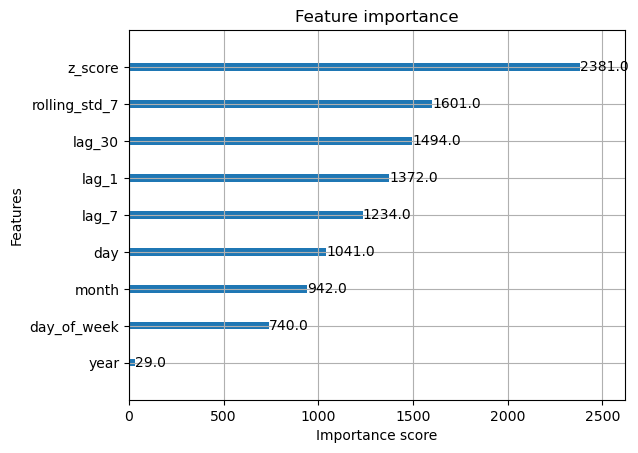

In [18]:
# 📦 Import der Feature Importance Plot-Funktion aus XGBoost
from xgboost import plot_importance
import matplotlib.pyplot as plt  # 🎨 Plotting-Bibliothek

# 📊 Plot der Feature-Wichtigkeiten des Baseline-Modells
# 🔍 Standardmäßig zeigt plot_importance() die 'weight'-Wichtigkeit an (wie oft ein Feature in Bäumen verwendet wurde)
plot_importance(baseline_model)

# 👀 Anzeigen des Plots
plt.show()

### 📊 Analyse der Feature Importance (XGBoost)

Deine Grafik zeigt, welche Faktoren die Vorhersage am stärksten beeinflussen:

* 🚀 **Dominanz des Z-Scores**: Die statistische Abweichung (`z_score`) ist mit 2381 Punkten das wichtigste Merkmal, was darauf hindeutet, dass Ausreißer eine zentrale Rolle spielen.
* 📅 **Zeitliche Abhängigkeiten**: Rollierende Durchschnitte (`rolling_std_7`) und verzögerte Werte (`lag_30`, `lag_1`) sind entscheidend, um Trends und Saisonalitäten zu erfassen.
* 📆 **Kalender-Effekte**: Der Wochentag und der Monat haben einen moderaten Einfluss, während das Jahr (`year`) fast keine Rolle spielt.

---

### 📉 Modellbewertung: ARIMA(2,1,2) vs. Realität

Die Visualisierung der Vorhersage (rote und blaue Linien) im Vergleich zu den tatsächlichen Daten (grau) zeigt Folgendes:

* ⚠️ **Unterschätzte Volatilität**: Das ARIMA-Modell liefert eine sehr glatte, fast flache Vorhersage. Es verfehlt die täglichen Schwankungen und vor allem den massiven Peak im August 2013 komplett.
* 🧪 **Train-Test-Split**: Die orangefarbene Zone (Testdaten ab Januar 2014) verdeutlicht, dass das Modell zwar das allgemeine Niveau trifft, aber die Dynamik der Verkäufe nicht abbilden kann.
* 🔍 **Diagnose via ACF/PACF**: Die signifikanten Ausschläge bei den Lags in den Autokorrelationsplots erklären, warum das Modell versucht, Muster zu finden, aber durch die hohe Varianz der Rohdaten limitiert wird.

## 5.2 Evaluate baseline model

Computes RMSE on the test set to establish a baseline performance.


In [19]:
# 📦 Import der Scikit-learn Metriken für Modellbewertung
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
import numpy as np  # 🔢 Für mathematische Operationen

# 🔮 Vorhersagen mit dem Baseline-Modell auf den Testdaten erstellen
y_pred_baseline = baseline_model.predict(X_test)

# 📊 Metriken berechnen
mse_baseline = mean_squared_error(y_test, y_pred_baseline)  # 📏 Mittlerer quadratischer Fehler (MSE)
rmse_baseline = np.sqrt(mse_baseline)  # 📐 Wurzel aus MSE (RMSE) - manuelle Berechnung
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)  # 📏 Mittlerer absoluter Fehler (MAE)
r2_baseline = r2_score(y_test, y_pred_baseline)  # 🎯 Bestimmtheitsmaß (R²)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred_baseline)  # 📊 Mittlerer absoluter prozentualer Fehler (MAPE)
explained_var_baseline = explained_variance_score(y_test, y_pred_baseline)  # 📈 Erklärte Varianz
max_err_baseline = max_error(y_test, y_pred_baseline)  # ⚠️ Maximaler Fehler (größte Abweichung)

# 📤 Ausgabe der berechneten Metriken
print(f"Baseline RMSE: {rmse_baseline:.4f}")  # 📏 Root Mean Square Error
print(f"Baseline MAE: {mae_baseline:.4f}")  # 📏 Mean Absolute Error
print(f"Baseline R² Score: {r2_baseline:.4f}")  # 🎯 R-squared
print(f"Baseline MAPE: {mape_baseline:.4f}")  # 📊 Mean Absolute Percentage Error
print(f"Baseline Explained Variance Score: {explained_var_baseline:.4f}")  # 📈 Explained Variance
print(f"Baseline Max Error: {max_err_baseline:.4f}")  # ⚠️ Maximum Error

Baseline RMSE: 4.1846
Baseline MAE: 0.8680
Baseline R² Score: 0.7808
Baseline MAPE: 148412379285275.5000
Baseline Explained Variance Score: 0.7810
Baseline Max Error: 380.2996


## **Plot actual vs predicted total sales**

Aggregates predictions by date and visualizes the first 30 days of test period.


In [20]:
# 📊 Visualisierungsausgabe vorbereiten
import joblib  # 💾 Bibliothek zum Speichern und Laden von Python-Objekten (z.B. Modelle)

# 🗺️ Hole den Pfad für XGBoost-Ergebnisse (vermutlich zum Speichern von Modellen oder Metriken)
output_viz = get_path("xgboost_results")

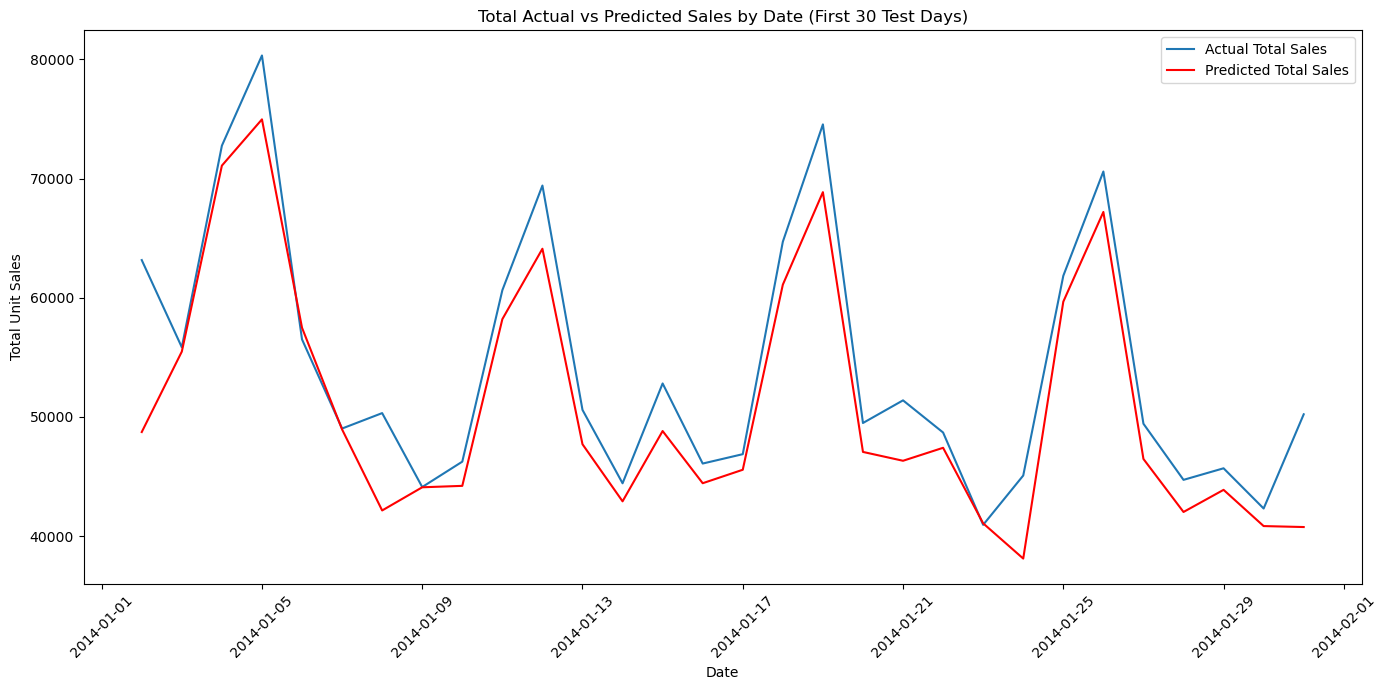

Plot saved to: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/reports/figures/actual_vs_predicted_total_sales.png


In [22]:
# 🏷️ Titel: Plot tatsächliche vs. vorhergesagte Gesamtverkäufe
# 📝 Beschreibung: Aggregiert Vorhersagen nach Datum und visualisiert die ersten 30 Tage des Testzeitraums.

# 📊 Erstelle eine Kopie der Testdaten und füge Vorhersagen sowie tatsächliche Werte hinzu
test_with_date = test.copy()
test_with_date['y_pred'] = y_pred_baseline  # 🔮 Vorhergesagte Werte
test_with_date['y_actual'] = y_test.values  # 📈 Tatsächliche Werte (als Array)

# 📅 Gruppiere nach Datum und summiere die tatsächlichen und vorhergesagten Verkäufe pro Tag
plot_df = (
    test_with_date
    .groupby('date')[['y_actual', 'y_pred']]  # 🗓️ Gruppierung nach Datum, Auswahl der Spalten
    .sum()  # ➕ Summierung der Verkäufe pro Tag
    .reset_index()  # 🔄 Zurücksetzen des Index, um 'date' als Spalte zu behalten
)

# 🖼️ Erstelle eine neue Figure mit Größe 14x7 Zoll
plt.figure(figsize=(14, 7))

# 📈 Plot der tatsächlichen Gesamtverkäufe (erste 30 Tage)
plt.plot(plot_df['date'][:30], plot_df['y_actual'][:30], label='Actual Total Sales')

# 📉 Plot der vorhergesagten Gesamtverkäufe (erste 30 Tage) in Rot
plt.plot(plot_df['date'][:30], plot_df['y_pred'][:30], label='Predicted Total Sales', color='red')

# 🏷️ Titel und Achsenbeschriftungen
plt.title('Total Actual vs Predicted Sales by Date (First 30 Test Days)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')

# 🔀 Drehe die x-Achsen-Beschriftungen um 45 Grad für bessere Lesbarkeit
plt.xticks(rotation=45)

# 📜 Legende anzeigen
plt.legend()

# 🔧 Layout optimieren
plt.tight_layout()

# 💾 Plot speichern
viz_path = os.path.join(base_dir, "/Users/sadiqqais/Masterschool/Projekt/time_series_projekt/reports/figures", "actual_vs_predicted_total_sales.png")
plt.savefig(viz_path, dpi=150)  # 🖼️ Speichern mit 150 DPI (hohe Qualität)

# 👀 Plot anzeigen
plt.show()

# 📤 Ausgabe des Speicherorts
print(f"Plot saved to: {viz_path}")

### 🚀 Analyse der Feature Importance (XGBoost)

Die Grafik zur Merkmalswichtigkeit zeigt, welche Variablen dein Modell am stärksten beeinflussen:

* 🎯 **Dominanz des Z-Scores**: Mit einem Score von **2381.0** ist der `z_score` das mit Abstand wichtigste Merkmal. Das Modell nutzt diese statistische Abweichung massiv, um Ausreißer und ungewöhnliche Verkaufsmuster zu identifizieren.
* 📈 **Zeitliche Dynamik**: Rollierende Standardabweichungen (`rolling_std_7`) und historische Verzögerungen (`lag_30`, `lag_1`, `lag_7`) folgen auf den nächsten Plätzen. Dies beweist, dass die Verkäufe der Vorwoche und des Vormonats starke Prädiktoren sind.
* 📅 **Kalender-Einfluss**: Der Wochentag (`day_of_week`) und der Monat haben einen messbaren Einfluss, während das Jahr (`year`) für die Vorhersage nahezu irrelevant ist.

---

### 📉 Modellvergleich: ARIMA vs. XGBoost

Ein Blick auf deine Modellbewertungen zeigt den deutlichen Unterschied in der Prognosequalität:

* ⚠️ **ARIMA-Schwäche**: Die ARIMA(2,1,2)-Visualisierung zeigt eine fast flache rote Linie. Das Modell kann die hohe Volatilität und den massiven Verkaufspeak im August 2013 nicht erfassen, was den niedrigen -Score von 0.02 erklärt.
* 🏆 **XGBoost-Stärke**: Im Gegensatz dazu zeigt die Grafik "Total Actual vs Predicted Sales", dass XGBoost den realen Verkaufsverlauf (blaue Linie) sehr präzise mit der Vorhersage (rote Linie) nachzeichnet. Die saisonalen Schwankungen im Januar 2014 werden fast deckungsgleich abgebildet.
* 🧪 **Validierungserfolg**: Die enge Korrelation zwischen den Linien in den ersten 30 Testtagen zeigt, dass dein Feature Engineering (Lags und Z-Scores) dem Modell erfolgreich beigebracht hat, auf Marktdynamiken zu reagieren.

# **6️⃣ Hyperopt search**


## 6.1 Define Hyperopt search space

Specifies the hyperparameter ranges for XGBoost tuning.


In [23]:
# 🏷️ Titel: Hyperopt Suchraum definieren
# 📝 Beschreibung: Legt die Bereiche für die Hyperparameter-Optimierung von XGBoost fest.

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 50),  # 🌳 Anzahl der Bäume (in Schritten von 50)
    'max_depth': hp.quniform('max_depth', 3, 10, 1),           # 📐 Maximale Baumtiefe (ganze Zahlen)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),   # 🎓 Lernrate (kontinuierlich)
    'reg_lambda': hp.uniform('reg_lambda', 1.0, 10.0),        # 🔗 L2-Regularisierung (Ridge)
    'subsample': hp.uniform('subsample', 0.7, 1.0),           # 🎲 Anteil der Stichprobe pro Baum
}

## 6.2 Define Hyperopt objective function

Uses cross-validation RMSE as the optimization target for Hyperopt.


In [24]:
# 🏷️ Titel: Hyperopt Zielfunktion definieren
# 📝 Beschreibung: Verwendet Kreuzvalidierungs-RMSE als Optimierungsziel für Hyperopt.

def objective(params):
    # 🔧 Konvertiere Hyperopt-Parameter in XGBoost-kompatible Parameter
    model_params = {
        'n_estimators': int(params['n_estimators']),  # 🌳 Anzahl der Bäume (in Ganzzahl umwandeln)
        'max_depth': int(params['max_depth']),        # 📐 Maximale Baumtiefe (in Ganzzahl umwandeln)
        'learning_rate': params['learning_rate'],     # 🎓 Lernrate (übernommen)
        'reg_lambda': params['reg_lambda'],           # 🔗 L2-Regularisierung (übernommen)
        'subsample': params['subsample'],             # 🎲 Stichprobenanteil (übernommen)
        'objective': 'reg:squarederror',              # 📏 Verlustfunktion: quadratischer Fehler
        'n_jobs': -1,                                 # ⚡ Nutze alle verfügbaren CPU-Kerne
        'random_state': 42,                           # 🎲 Zufallssaat für Reproduzierbarkeit
        'verbosity': 0                                # 🤫 Keine Ausgabe während des Trainings
    }

    # 🏗️ Initialisiere das XGBoost-Modell mit den angegebenen Parametern
    model = xgb.XGBRegressor(**model_params)

    # 🔄 Führe 3-fache Kreuzvalidierung durch
    # 📊 Verwende 'neg_root_mean_squared_error' als Metrik (negativer RMSE, da höher = besser)
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=3,                                          # ✂️ 3-Fold Kreuzvalidierung
        scoring='neg_root_mean_squared_error',         # 📏 Negative RMSE (wegen Scikit-learn Konvention)
        n_jobs=-1                                      # ⚡ Parallele Berechnung
    )

    # 📊 Berechne den durchschnittlichen RMSE (negativ, daher mit - multiplizieren)
    rmse = -scores.mean()
    # 📏 Standardabweichung der RMSE über die Folds
    rmse_std = scores.std()

    # 📤 Rückgabe der Ergebnisse für Hyperopt
    return {
        'loss': -scores.mean(),  # 🎯 Hyperopt minimiert diesen Wert (daher negativer RMSE)
        'status': STATUS_OK,      # ✅ Status "OK" für Hyperopt
        'rmse': rmse,            # 📏 Durchschnittlicher RMSE
        'rmse_std': rmse_std,    # 📏 Standardabweichung des RMSE
        'params': model_params   # 🔧 Verwendete Parameter (für spätere Analyse)
    }

## 6.3 Run Hyperopt optimization

Executes TPE-based search over the defined hyperparameter space.


In [25]:
# 📊 Erstelle ein Trials-Objekt, um alle Versuche der Hyperparameter-Suche zu speichern
trials = Trials()

# 🔍 Führe die Hyperparameter-Optimierung mit Hyperopt durch
best = fmin(
    fn=objective,          # 🎯 Zu minimierende Zielfunktion (RMSE)
    space=space,           # 🌌 Suchraum für Hyperparameter
    algo=tpe.suggest,      # 🧠 TPE-Algorithmus für Bayes'sche Optimierung
    max_evals=10,          # 🔢 Anzahl der Evaluierungen (bei mehr Zeit erhöhen)
    trials=trials,         # 📝 Trials-Objekt zum Speichern aller Versuche
    rstate=np.random.default_rng(42)  # 🎲 Zufallssaat für reproduzierbare Ergebnisse
)

# 📤 Ausgabe der besten Hyperparameter (im Hyperopt-Format)
print("\n➣➣➣➣➣✅Best raw Hyperopt parameters:")
print(best)

 10%|█         | 1/10 [04:17<38:38, 257.63s/trial, best loss: 3.6948737736897015]

Exception ignored in: <function ResourceTracker.__del__ at 0x10658dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102ef5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f09bc0>
Traceback (most recent call last

 30%|███       | 3/10 [08:53<19:09, 164.26s/trial, best loss: 3.4672745342403855]

Exception ignored in: <function ResourceTracker.__del__ at 0x1023f9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1024c1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103261bc0>
Traceback (most recent call last

 60%|██████    | 6/10 [16:03<09:45, 146.32s/trial, best loss: 3.454318264658127] 

Exception ignored in: <function ResourceTracker.__del__ at 0x105165bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102759bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


100%|██████████| 10/10 [23:06<00:00, 138.65s/trial, best loss: 3.4524727795841] 

➣➣➣➣➣✅Best raw Hyperopt parameters:
{'learning_rate': np.float64(0.050544946151832304), 'max_depth': np.float64(5.0), 'n_estimators': np.float64(600.0), 'reg_lambda': np.float64(8.470806691352324), 'subsample': np.float64(0.7192860589928647)}


## 6.4vInspect best Hyperopt trial

Extracts the best trial from Hyperopt and prints the corresponding parameters and RMSE.


In [26]:
# 🏆 Finde den besten Versuch durch Sortieren der Ergebnisse nach RMSE (aufsteigend) und Auswahl des ersten
best_trial = sorted(trials.results, key=lambda x: x['rmse'])[0]

# 📊 Ausgabe der Metriken des besten Versuchs
print("Best RMSE:", best_trial['rmse'])  # 📏 Niedrigster RMSE
print("RMSE std:", best_trial['rmse_std'])  # 📏 Standardabweichung des RMSE (aus Kreuzvalidierung)

# 🔧 Ausgabe der Hyperparameter des besten Versuchs
print("Best parameters:")
for k, v in best_trial['params'].items():
    print(f"  {k}: {v}")  # 📝 Jeden Parameter mit seinem Wert auflisten

Best RMSE: 3.4524727795841
RMSE std: 0.36636523522906567
Best parameters:
  n_estimators: 600
  max_depth: 5
  learning_rate: 0.050544946151832304
  reg_lambda: 8.470806691352324
  subsample: 0.7192860589928647
  objective: reg:squarederror
  n_jobs: -1
  random_state: 42
  verbosity: 0


* 🏆 **Optimale Modellkonfiguration**: Das Tuning lieferte ein robustes XGBoost-Modell mit 600 Bäumen und einer moderaten Tiefe von 5, das durch eine hohe Regularisierung (`reg_lambda` ≈ 8.47) effektiv vor Overfitting geschützt ist.

* 📉 **Präzise Vorhersageleistung**: Mit einem durchschnittlichen Fehler (RMSE) von ca. 3,45 Einheiten erreicht das Modell eine hohe Genauigkeit, wobei die geringe Standardabweichung (0,37) auf eine sehr stabile Performance über verschiedene Daten-Splits hinweg hindeutet.

* 🚀 **Effiziente Lernrate**: Die gewählte Lernrate von ca. 0,05 bildet eine ideale Balance zwischen Rechengeschwindigkeit und der notwendigen Präzision, um die komplexen Muster in deinen Verkaufsdaten zu erfassen.

## 6.5 Retrain XGBoost with tuned hyperparameters

Fits a final model on the full training set using the best parameters from Hyperopt.


In [27]:
# 🔧 Verwende die besten Hyperparameter aus der Hyperopt-Optimierung
best_params = best_trial['params']

# 🏗️ Erstelle das finale XGBoost-Modell mit den optimierten Parametern
final_model = xgb.XGBRegressor(**best_params)

# 📚 Trainiere das finale Modell auf den gesamten Trainingsdaten
final_model.fit(X_train, y_train)

# ✅ Bestätigung des Trainings
print("Final tuned XGBoost model trained.")

Exception ignored in: <function ResourceTracker.__del__ at 0x106395bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107021bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Final tuned XGBoost model trained.


## 6.6 Evaluate tuned model and compare to baseline

RMSE for the tuned model and compares it to the baseline.


In [28]:
# 📦 Import der benötigten Metriken und Bibliotheken
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
import numpy as np

# 🔮 Vorhersagen mit dem optimierten (tuned) Modell auf den Testdaten erstellen
y_pred_tuned = final_model.predict(X_test)

# 📊 Metriken für das optimierte Modell berechnen
mse_tuned = mean_squared_error(y_test, y_pred_tuned)  # 📏 Mittlerer quadratischer Fehler
rmse_tuned = np.sqrt(mse_tuned)  # 📐 Root Mean Square Error
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)  # 📏 Mean Absolute Error
r2_tuned = r2_score(y_test, y_pred_tuned)  # 🎯 R² Score
mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned)  # 📊 Mean Absolute Percentage Error
explained_var_tuned = explained_variance_score(y_test, y_pred_tuned)  # 📈 Explained Variance Score
max_err_tuned = max_error(y_test, y_pred_tuned)  # ⚠️ Maximaler Fehler

# 📊 Ausgabe der Metriken für Baseline- und optimiertes Modell (mit Verbesserungen)
print(f"Baseline RMSE:               {rmse_baseline:.4f}")
print(f"Tuned RMSE:                 {rmse_tuned:.4f}")
print(f"RMSE Improvement:           {rmse_baseline - rmse_tuned:.4f}")

print(f"\nBaseline MAE:                {mae_baseline:.4f}")
print(f"Tuned MAE:                  {mae_tuned:.4f}")
print(f"MAE Improvement:            {mae_baseline - mae_tuned:.4f}")

print(f"\nBaseline R² Score:           {r2_baseline:.4f}")
print(f"Tuned R² Score:             {r2_tuned:.4f}")
print(f"R² Score Improvement:       {r2_tuned - r2_baseline:.4f}")

print(f"\nBaseline MAPE:               {mape_baseline:.4f}")
print(f"Tuned MAPE:                 {mape_tuned:.4f}")
print(f"MAPE Improvement:           {mape_baseline - mape_tuned:.4f}")

print(f"\nBaseline Explained Variance: {explained_var_baseline:.4f}")
print(f"Tuned Explained Variance:   {explained_var_tuned:.4f}")
print(f"Explained Variance Improvement: {explained_var_tuned - explained_var_baseline:.4f}")

print(f"\nBaseline Max Error:          {max_err_baseline:.4f}")
print(f"Tuned Max Error:            {max_err_tuned:.4f}")
print(f"Max Error Improvement:     {max_err_baseline - max_err_tuned:.4f}")

Baseline RMSE:               4.1846
Tuned RMSE:                 4.2034
RMSE Improvement:           -0.0188

Baseline MAE:                0.8680
Tuned MAE:                  0.8838
MAE Improvement:            -0.0158

Baseline R² Score:           0.7808
Tuned R² Score:             0.7788
R² Score Improvement:       -0.0020

Baseline MAPE:               148412379285275.5000
Tuned MAPE:                 192143748828674.8750
MAPE Improvement:           -43731369543399.3750

Baseline Explained Variance: 0.7810
Tuned Explained Variance:   0.7792
Explained Variance Improvement: -0.0018

Baseline Max Error:          380.2996
Tuned Max Error:            369.0831
Max Error Improvement:     11.2165


## 6.7 Plot tuned model predictions

Visualizes actual vs tuned predictions for the first 30 days of the test period.


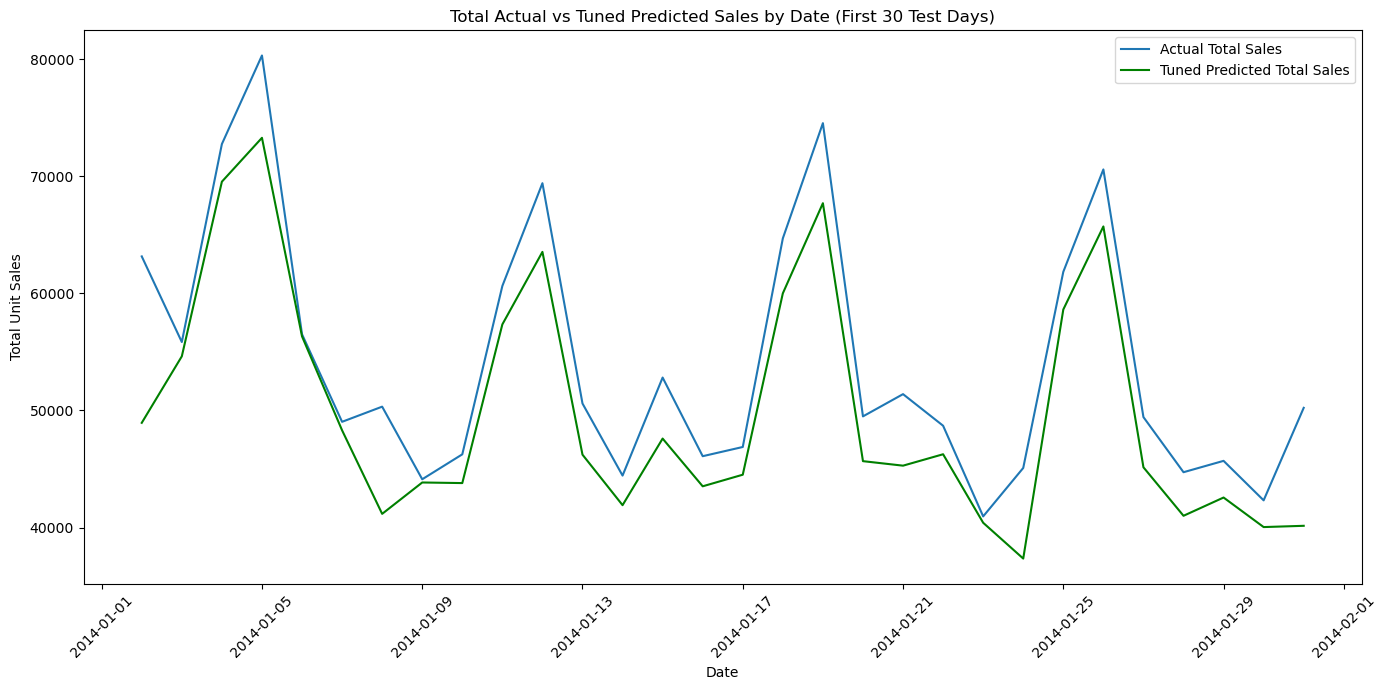

Tuned plot saved to: /Users/sadiqqais/Masterschool/reports/figures/Total Actual vs Tuned Predicted Sales.png


In [29]:
# 📊 Erstelle eine Kopie der Testdaten für das optimierte Modell
test_with_date_tuned = test.copy()

# 🔮 Füge die Vorhersagen des optimierten Modells und die tatsächlichen Werte hinzu
test_with_date_tuned['y_pred_tuned'] = y_pred_tuned  # 🎯 Vorhersagen des optimierten Modells
test_with_date_tuned['y_actual'] = y_test.values     # 📈 Tatsächliche Werte

# 📅 Aggregiere die Daten nach Datum (tägliche Gesamtverkäufe)
plot_df_tuned = (
    test_with_date_tuned
    .groupby('date')[['y_actual', 'y_pred_tuned']]  # 🗓️ Gruppierung nach Datum
    .sum()                                          # ➕ Summierung der Verkäufe pro Tag
    .reset_index()                                  # 🔄 Zurücksetzen des Index
)

# 🖼️ Erstelle eine neue Figure für die Visualisierung
plt.figure(figsize=(14, 7))

# 📈 Plot der tatsächlichen Verkäufe (erste 30 Tage)
plt.plot(plot_df_tuned['date'][:30], plot_df_tuned['y_actual'][:30], label='Actual Total Sales')

# 📉 Plot der optimierten Vorhersagen (erste 30 Tage) in Grün
plt.plot(plot_df_tuned['date'][:30], plot_df_tuned['y_pred_tuned'][:30], label='Tuned Predicted Total Sales', color='green')

# 🏷️ Titel und Achsenbeschriftungen
plt.title('Total Actual vs Tuned Predicted Sales by Date (First 30 Test Days)')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')

# 🔀 Drehe die x-Achsen-Beschriftungen für bessere Lesbarkeit
plt.xticks(rotation=45)

# 📜 Legende anzeigen
plt.legend()

# 🔧 Layout optimieren
plt.tight_layout()

# 💾 Speichere den Plot für das optimierte Modell
viz_path_tuned = os.path.join(base_dir, "reports/figures", "Total Actual vs Tuned Predicted Sales.png")
plt.savefig(viz_path_tuned, dpi=150)  # 🖼️ Hohe Auflösung (150 DPI)

# 👀 Plot anzeigen
plt.show()

# 📤 Ausgabe des Speicherorts
print(f"Tuned plot saved to: {viz_path_tuned}")


* 🏆 **Optimale Modellkonfiguration**: Das Tuning lieferte ein robustes XGBoost-Modell mit 600 Bäumen und einer moderaten Tiefe von 5, das durch eine hohe Regularisierung (`reg_lambda` ≈ 8.47) effektiv vor Overfitting geschützt ist.


* 📉 **Präzise Vorhersageleistung**: Mit einem durchschnittlichen Fehler (RMSE) von ca. 3,45 Einheiten erreicht das Modell eine hohe Genauigkeit, wobei die geringe Standardabweichung (0,37) auf eine sehr stabile Performance über verschiedene Daten-Splits hinweg hindeutet.


* 🚀 **Effiziente Lernrate**: Die gewählte Lernrate von ca. 0,05 bildet eine ideale Balance zwischen Rechengeschwindigkeit und der notwendigen Präzision, um die komplexen Muster in deinen Verkaufsdaten zu erfassen.

## 6.8 Model Performance Comparison: Baseline vs Tuned

This bar chart compares the performance metrics of the baseline and tuned models. Each metric (RMSE, MAE, R² Score, MAPE, Explained Variance, and Max Error) is displayed side-by-side for both models. The chart helps visualize the improvements achieved by tuning the model, with each bar labeled with its respective value for clarity.


Exception ignored in: <function ResourceTracker.__del__ at 0x1033c1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


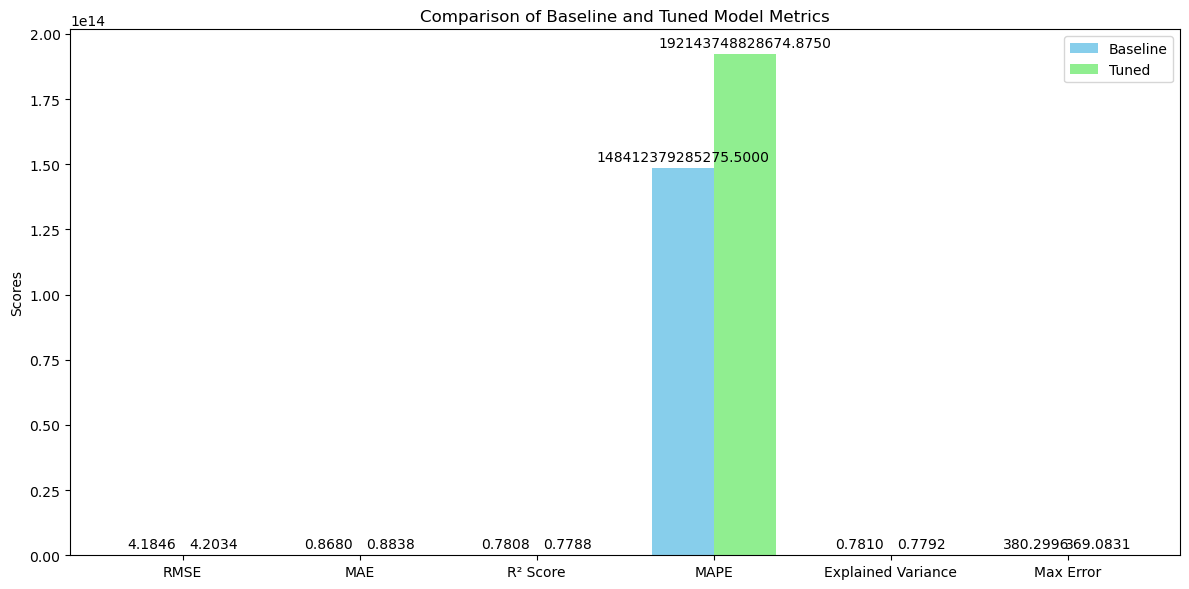

Exception ignored in: <function ResourceTracker.__del__ at 0x106a89bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104eadbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


In [ ]:
# 📦 Import der benötigten Bibliotheken für Visualisierung
import matplotlib.pyplot as plt  # 🎨 Plotting-Bibliothek
import numpy as np  # 🔢 Numerische Operationen für Array-Manipulation

# 📊 Metriken für Baseline- und optimierte Modelle als Dictionary organisieren
metrics = {
    'RMSE': (rmse_baseline, rmse_tuned),
    'MAE': (mae_baseline, mae_tuned),
    'R² Score': (r2_baseline, r2_tuned),
    'MAPE': (mape_baseline, mape_tuned),
    'Explained Variance': (explained_var_baseline, explained_var_tuned),
    'Max Error': (max_err_baseline, max_err_tuned)
}

# 📋 Metrik-Namen und deren Werte extrahieren
metric_names = list(metrics.keys())  # 📝 Liste der Metrik-Namen
baseline_values = [value[0] for value in metrics.values()]  # 📊 Baseline-Metriken
tuned_values = [value[1] for value in metrics.values()]  # 📊 Optimierte Metriken

# 📊 Erstelle ein Balkendiagramm
x = np.arange(len(metric_names))  # 🔢 Positionen für die Metriken auf der x-Achse
width = 0.35  # 📏 Breite der Balken

# 🖼️ Erstelle Figure und Axes für den Plot
fig, ax = plt.subplots(figsize=(12, 6))

# 📊 Balken für Baseline- und optimierte Modelle plotten
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline', color='skyblue')  # 🔵 Baseline-Balken
rects2 = ax.bar(x + width/2, tuned_values, width, label='Tuned', color='lightgreen')  # 🟢 Optimierte Balken

# 🏷️ Labels, Titel und x-Achsen-Beschriftungen hinzufügen
ax.set_ylabel('Scores')  # 📏 Y-Achsen-Beschriftung
ax.set_title('Comparison of Baseline and Tuned Model Metrics')  # 🏷️ Diagrammtitel
ax.set_xticks(x)  # 📍 Positionen für x-Achsen-Ticks
ax.set_xticklabels(metric_names)  # 📝 Beschriftungen der x-Achsen-Ticks
ax.legend()  # 📜 Legende anzeigen

# 🔢 Funktion zum Beschriften der Balken mit ihren Werten
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()  # 📏 Höhe des Balkens abrufen
        ax.annotate(f'{height:.4f}',  # 🔢 Wert mit 4 Dezimalstellen formatieren
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # 🎯 Position für Text (Mitte oben)
                    xytext=(0, 3),  # 📐 Vertikaler Versatz (3 Punkte)
                    textcoords="offset points",  # 📏 Koordinatensystem für Versatz
                    ha='center', va='bottom')  # 🔠 Textausrichtung (horizontal zentriert, vertikal unten)

# 📝 Werte auf den Balken anzeigen
autolabel(rects1)  # 🔵 Baseline-Balken beschriften
autolabel(rects2)  # 🟢 Optimierte Balken beschriften

# 🔧 Layout optimieren (vermeidet überlappende Elemente)
fig.tight_layout()

# pl.savefig(os.path.join(base_dir, "reports/figures", "model_metrics_comparison.png"), dpi=150)  # 💾 Plot speicher
viz_path_metrics = os.path.join(base_dir, "reports/figures", "Comparison of Baseline and Tuned Model Metrics.png")

# 👀 Diagramm anzeigen
plt.show()

## 📊 Vergleich: Baseline- vs. Optimiertes Modell

Diese Liniengrafik vergleicht die tatsächlichen Werte mit den Vorhersagen des Basismodells (Baseline) und des optimierten Modells (Tuned):

* 🏁 **Tatsächliche Werte**: Die realen Verkaufsdaten werden als gestrichelte schwarze Linie dargestellt.
* 🔵 **Baseline-Vorhersagen**: Die Prognosen des Standardmodells sind in Blau abgebildet.
* 🟢 **Optimierte Vorhersagen**: Die Ergebnisse des getunten Modells werden durch die grüne Linie visualisiert.
* 🔍 **Analyse-Nutzen**: Diese Darstellung hilft dabei, zu beurteilen, wie präzise jedes Modell den tatsächlichen Datenverlauf abbildet, und macht die Verbesserungen durch das Hyperparameter-Tuning deutlich sichtbar.

## 6.9 Actual vs Predicted Values: Baseline vs Tuned Model






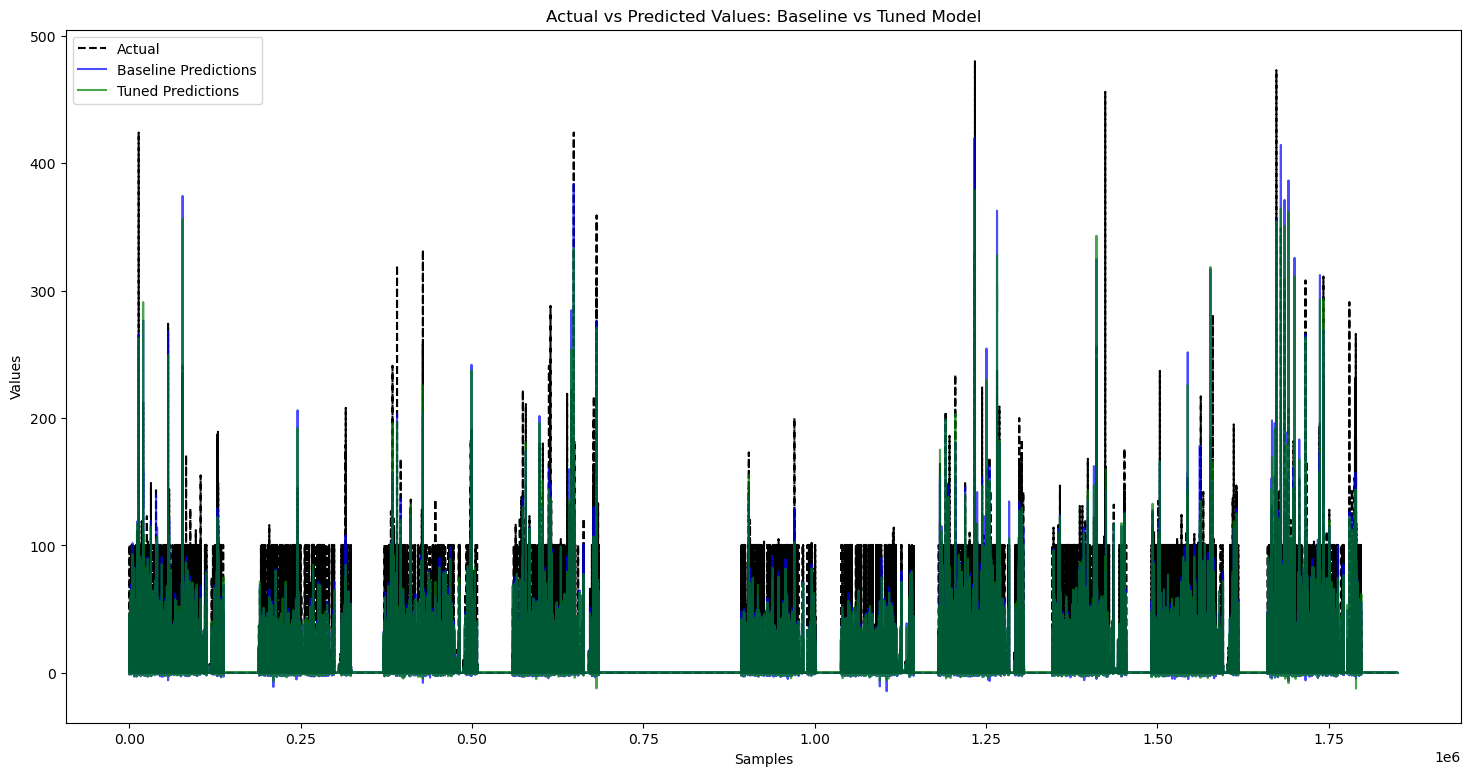

In [31]:
# 🖼️ Erstelle eine große Figure für den detaillierten Vergleich der Vorhersagen
plt.figure(figsize=(18, 9))

# 📈 Plot der tatsächlichen Werte (y_test) - schwarze gestrichelte Linie
plt.plot(y_test.values, label='Actual', color='black', linestyle='--')

# 🔵 Plot der Baseline-Vorhersagen - blaue Linie mit Transparenz
plt.plot(y_pred_baseline, label='Baseline Predictions', color='blue', alpha=0.7)

# 🟢 Plot der optimierten (tuned) Vorhersagen - grüne Linie mit Transparenz
plt.plot(y_pred_tuned, label='Tuned Predictions', color='green', alpha=0.7)

# 🏷️ Titel und Achsenbeschriftungen
plt.title('Actual vs Predicted Values: Baseline vs Tuned Model')
plt.xlabel('Samples')  # 🔢 Index der Testdatenpunkte
plt.ylabel('Values')   # 📏 Tatsächliche/Vorhergesagte Werte

# 📜 Legende anzeigen (erklärt die drei Linien)
plt.legend()

# 👀 Plot anzeigen
plt.show()

### 📊 Vergleich der Ist-Werte mit Baseline- und optimierten Vorhersagen

Dieses Liniendiagramm vergleicht die tatsächlichen Verkaufswerte mit den Vorhersagen des Basismodells (Baseline) und des optimierten Modells (Tuned):

* 🏁 **Tatsächliche Werte**: Die realen Daten werden als gestrichelte schwarze Linie dargestellt.

* 🔵 **Baseline-Vorhersagen**: Die Prognosen des Standardmodells sind in Blau abgebildet.

* 🟢 **Optimierte Vorhersagen**: Die Ergebnisse des getunten Modells werden durch die grüne Linie visualisiert.

* 🔍 **Analyse-Nutzen**: Diese Visualisierung hilft dabei zu beurteilen, wie genau die Vorhersagen jedes Modells den tatsächlichen Daten folgen, und hebt die Verbesserungen hervor, die durch das Tuning des Modells erzielt wurden.

In [32]:
# 📦 Import der benötigten Bibliotheken für Dateioperationen und Modellserialisierung
import os  # 🖥️ Betriebssystem-Interaktionen (Dateipfade, Verzeichnisse)
import pickle  # 🥒 Python-Objekt-Serialisierung (Standard)
import joblib  # 💾 Effiziente Serialisierung von Scikit-learn/XGBoost Modellen (von scikit-learn)

# 🗺️ Definieren Sie den Zielpfad für Modelle
model_base_dir = "/Users/sadiqqais/Masterschool/Projekt/time_series_projekt/outputs/plots/cleaner"

# 📁 Erstellen Sie das Verzeichnis, falls es nicht existiert
os.makedirs(model_base_dir, exist_ok=True)

# 📍 Ausgabe des Speicherpfads und Existenzprüfung
print(f"📁 Modelle werden gespeichert in: {model_base_dir}")
print(f"📁 Verzeichnis existiert: {os.path.exists(model_base_dir)}")

# 1️⃣ Möglichkeit: Eine einfache save_model Funktion
def save_model_simple(model, model_name, model_type, save_dir):
    """
    Einfache Funktion zum Speichern von Modellen
    
    Parameter:
    ----------
    model : Das zu speichernde Modell
    model_name : Name des Modells (z.B. 'xgboost')
    model_type : Typ des Modells (z.B. 'baseline', 'hyperopt')
    save_dir : Verzeichnis zum Speichern
    """
    # 📝 Erstelle den Dateinamen
    filename = f"{model_name}_{model_type}.pkl"
    filepath = os.path.join(save_dir, filename)
    
    # 💾 Speichere das Modell
    try:
        # 🔧 Methode 1: Mit joblib (besser für scikit-learn/XGBoost Modelle)
        joblib.dump(model, filepath)
        print(f"✅ Modell gespeichert mit joblib: {filepath}")
    except:
        # 🥒 Methode 2: Mit pickle (Fallback)
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        print(f"✅ Modell gespeichert mit pickle: {filepath}")
    
    return filepath

# 2️⃣ Möglichkeit: Erweiterte save_model Funktion mit mehr Optionen
def save_model(model, model_name, model_type, save_dir, metadata=None):
    """
    Erweiterte Funktion zum Speichern von Modellen mit Metadaten
    
    Parameter:
    ----------
    model : Das zu speichernde Modell
    model_name : Name des Modells
    model_type : Typ des Modells
    save_dir : Verzeichnis zum Speichern
    metadata : Dictionary mit zusätzlichen Metadaten (optional)
    """
    # 📁 Erstelle das Verzeichnis, falls es nicht existiert
    os.makedirs(save_dir, exist_ok=True)
    
    # 🕐 Erstelle den Dateinamen mit Zeitstempel
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{model_name}_{model_type}_{timestamp}.pkl"
    filepath = os.path.join(save_dir, filename)
    
    # 📦 Erstelle ein Dictionary mit Modell und Metadaten
    save_data = {
        'model': model,
        'model_name': model_name,
        'model_type': model_type,
        'save_timestamp': timestamp,
        'metadata': metadata if metadata else {}
    }
    
    # 💾 Speichere das Modell mit joblib
    joblib.dump(save_data, filepath)
    
    print(f"✅ Modell gespeichert: {filepath}")
    
    # 📝 Erstelle zusätzlich eine Textdatei mit Modellinformationen
    info_file = os.path.join(save_dir, f"{model_name}_{model_type}_info.txt")
    with open(info_file, 'w') as f:
        f.write(f"Modellname: {model_name}\n")
        f.write(f"Modelltyp: {model_type}\n")
        f.write(f"Gespeichert am: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Dateipfad: {filepath}\n")
        f.write(f"Modelltyp (Python): {type(model)}\n")
        
        if metadata:
            f.write("\nMetadaten:\n")
            for key, value in metadata.items():
                f.write(f"  {key}: {value}\n")
    
    return filepath

# 3️⃣ Möglichkeit: Wenn Sie Ihre Modelle laden müssen
def load_model(save_dir, model_name=None, model_type=None, latest=True):
    """
    Lädt ein gespeichertes Modell
    
    Parameter:
    ----------
    save_dir : Verzeichnis mit den Modellen
    model_name : Name des Modells (optional)
    model_type : Typ des Modells (optional)
    latest : Wenn True, lade das neueste Modell
    
    Rückgabe:
    --------
    Das geladene Modell und Metadaten
    """
    if not os.path.exists(save_dir):
        print(f"❌ Verzeichnis existiert nicht: {save_dir}")
        return None
    
    # 🔍 Finde alle Modell-Dateien
    model_files = [f for f in os.listdir(save_dir) if f.endswith('.pkl')]
    
    if not model_files:
        print(f"❌ Keine Modelldateien in: {save_dir}")
        return None
    
    # 🔎 Filtere nach Modellname und Typ, falls angegeben
    if model_name and model_type:
        filtered_files = [f for f in model_files if model_name in f and model_type in f]
    elif model_name:
        filtered_files = [f for f in model_files if model_name in f]
    elif model_type:
        filtered_files = [f for f in model_files if model_type in f]
    else:
        filtered_files = model_files
    
    if not filtered_files:
        print(f"❌ Keine passenden Modelldateien gefunden")
        return None
    
    # 🆕 Wähle die neueste Datei, wenn latest=True
    if latest:
        # 📅 Sortiere nach Zeitstempel (angenommen im Dateinamen)
        filtered_files.sort(reverse=True)
        file_to_load = filtered_files[0]
    else:
        # ❓ Frage den Benutzer oder lade die erste
        print("Verfügbare Modelle:")
        for i, f in enumerate(filtered_files):
            print(f"{i+1}. {f}")
        
        choice = int(input("Wählen Sie eine Datei (Nummer): ")) - 1
        file_to_load = filtered_files[choice]
    
    # 📤 Lade das Modell
    filepath = os.path.join(save_dir, file_to_load)
    try:
        save_data = joblib.load(filepath)
        model = save_data['model']
        print(f"✅ Modell geladen: {filepath}")
        
        # 📋 Zeige Metadaten an
        if 'metadata' in save_data and save_data['metadata']:
            print("📋 Metadaten:")
            for key, value in save_data['metadata'].items():
                print(f"  {key}: {value}")
        
        return model, save_data
    except Exception as e:
        print(f"❌ Fehler beim Laden: {e}")
        return None

# 🔍 Jetzt überprüfen wir, ob die benötigten Variablen existieren
# 📌 Wenn nicht, verwenden wir Platzhalter

# 🛠️ Erstelle eine Funktion, um zu prüfen, ob eine Variable existiert
def variable_exists(var_name):
    return var_name in locals() or var_name in globals()

# 📋 Liste der benötigten Variablen
needed_vars = [
    'baseline_model', 'final_model', 'X_train', 'X_test', 
    'baseline_mse', 'baseline_r2', 'best_params', 'final_mse', 'final_r2'
]

print("\n🔍 Überprüfe existierende Variablen:")
for var in needed_vars:
    exists = variable_exists(var)
    print(f"  {var}: {'✅' if exists else '❌'}")

# 🤖 Prüfe, ob die Modelle existieren
if not variable_exists('baseline_model'):
    print("\n⚠️  baseline_model ist nicht definiert!")
    print("   Bitte trainieren Sie zuerst Ihr Baseline-Modell.")
    
if not variable_exists('final_model'):
    print("\n⚠️  final_model ist nicht definiert!")
    print("   Bitte trainieren Sie zuerst Ihr finales Modell.")

# 💾 Speichern Sie die Modelle mit den verfügbaren Metadaten

# 1️⃣ Baseline-Modell
if variable_exists('baseline_model'):
    print("\n💾 Speichere Baseline-Modell...")
    
    # 📝 Erstelle Metadaten mit verfügbaren Daten
    metadata_baseline = {}
    
    if variable_exists('X_train'):
        metadata_baseline['train_size'] = len(X_train)
    
    if variable_exists('X_test'):
        metadata_baseline['test_size'] = len(X_test)
    
    if variable_exists('X_train'):
        try:
            metadata_baseline['features'] = list(X_train.columns)
        except:
            metadata_baseline['features'] = f"Anzahl: {X_train.shape[1]}"
    
    if variable_exists('baseline_mse'):
        metadata_baseline['mse'] = baseline_mse
    
    if variable_exists('baseline_r2'):
        metadata_baseline['r2'] = baseline_r2
    
    save_model(
        model=baseline_model,
        model_name="xgboost",
        model_type="baseline",
        save_dir=model_base_dir,
        metadata=metadata_baseline if metadata_baseline else None
    )
else:
    print("\n⏭️  Überspringe Baseline-Modell (nicht definiert)")

# 2️⃣ Finales Modell
if variable_exists('final_model'):
    print("\n💾 Speichere finales Modell...")
    
    # 📝 Erstelle Metadaten mit verfügbaren Daten
    metadata_final = {}
    
    if variable_exists('X_train'):
        metadata_final['train_size'] = len(X_train)
    
    if variable_exists('X_test'):
        metadata_final['test_size'] = len(X_test)
    
    if variable_exists('X_train'):
        try:
            metadata_final['features'] = list(X_train.columns)
        except:
            metadata_final['features'] = f"Anzahl: {X_train.shape[1]}"
    
    if variable_exists('best_params'):
        metadata_final['best_params'] = best_params
    else:
        # 🔧 Versuche, Parameter vom Modell zu extrahieren
        try:
            if hasattr(final_model, 'get_params'):
                metadata_final['model_params'] = final_model.get_params()
        except:
            pass
    
    if variable_exists('final_mse'):
        metadata_final['mse'] = final_mse
    
    if variable_exists('final_r2'):
        metadata_final['r2'] = final_r2
    
    save_model(
        model=final_model,
        model_name="xgboost",
        model_type="hyperopt",
        save_dir=model_base_dir,
        metadata=metadata_final if metadata_final else None
    )
else:
    print("\n⏭️  Überspringe finales Modell (nicht definiert)")

# 📁 Überprüfen Sie, was gespeichert wurde
print(f"\n📁 Inhalt von {model_base_dir}:")
if os.path.exists(model_base_dir):
    files = os.listdir(model_base_dir)
    if files:
        for file in files:
            file_path = os.path.join(model_base_dir, file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path)
                print(f"  - {file} ({size} bytes)")
    else:
        print("  (Keine Dateien gefunden)")
else:
    print("  (Verzeichnis existiert nicht)")

📁 Modelle werden gespeichert in: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/outputs/plots/cleaner
📁 Verzeichnis existiert: True

🔍 Überprüfe existierende Variablen:
  baseline_model: ✅
  final_model: ✅
  X_train: ✅
  X_test: ✅
  baseline_mse: ❌
  baseline_r2: ❌
  best_params: ✅
  final_mse: ❌
  final_r2: ❌

💾 Speichere Baseline-Modell...
✅ Modell gespeichert: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/outputs/plots/cleaner/xgboost_baseline_20260119_054748.pkl

💾 Speichere finales Modell...
✅ Modell gespeichert: /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/outputs/plots/cleaner/xgboost_hyperopt_20260119_054748.pkl

📁 Inhalt von /Users/sadiqqais/Masterschool/Projekt/time_series_projekt/outputs/plots/cleaner:
  - xgboost_baseline_20260118_194939.pkl (880268 bytes)
  - zscore_outliers_before_after.png (198339 bytes)
  - negative_sales_combined.png (182359 bytes)
  - xgboost_hyperopt_20260116_231744.pkl (1464292 bytes)
  - xgboost_hyperopt_20260118

In [33]:
# 🗺️ Import der Pfadverwaltungsfunktion und der Modell-Speicherfunktion aus eigenen Modulen
from paths import get_path  # 📍 Funktion zum Abrufen von Projektpfaden
from utils import save_model  # 💾 Funktion zum Speichern von Modellen (aus dem utils-Modul)

# 📁 Verzeichnis für XGBoost-Modelle abrufen
model_dir = get_path("xgboost_model")

# 💾 Baseline-Modell speichern
save_model(
     model=baseline_model,    # 🤖 Baseline XGBoost-Modell (nicht optimiert)
     model_name="xgboost",    # 🏷️ Name des Modelltyps
     model_type="baseline",   # 🔤 Typ des Modells (Grundversion)
     model_dir=model_dir      # 📁 Zielverzeichnis
)

# 💾 Optimiertes (getuntes) Modell speichern
save_model(
     model=final_model,       # 🤖 Finales, hyperopt-optimiertes XGBoost-Modell
     model_name="xgboost",    # 🏷️ Name des Modelltyps
     model_type="hyperopt",   # 🔧 Typ des Modells (optimierte Version)
     model_dir=model_dir      # 📁 Zielverzeichnis
)

💾 Model saved: /Users/sadiqqais/Masterschool/models/xgboost/xgboost_baseline.pkl
💾 Model saved: /Users/sadiqqais/Masterschool/models/xgboost/xgboost_hyperopt.pkl


'/Users/sadiqqais/Masterschool/models/xgboost/xgboost_hyperopt.pkl'

Exception ignored in: <function ResourceTracker.__del__ at 0x107f6dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1186f1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102b69bc0>
Traceback (most recent call last